На основе ТЕХНИЧЕСКОГО РЕГЛАМЕНТА ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА" сделайте нейро-консультанта, отвечающего на вопросы по документу.
Проработайте промпт самостоятельно. Нейро-консультант не должен отвечать на вопросы, не касающиеся документа (необходимо предусмотреть это в промпте).
Поэкспериментируйте со сплиттерами, найдите оптимальный вариант.
Сделайте нейро-консультанта, проверьте его работу на самостоятельно-сформулированных вопросах (достаточно 2-3)

Ссылка на регламент: https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw

In [ ]:
!pip install faiss-cpu langchain==0.0.271 openai tiktoken

In [ ]:
import os
import getpass
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
import re
import requests
import openai
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import MarkdownHeaderTextSplitter
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage
import tiktoken
from langchain.docstore.document import Document
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

OpenAI API Key:··········


In [ ]:
# Функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний
data_from_url= load_document_text('https://docs.google.com/document/d/19VvxPObQvltpeLUg9WfZDm8NZuzFGUITTGgaOY_3L6g/edit?usp=sharing')

In [ ]:
data_from_url[:2000]

'\ufeffТЕХНИЧЕСКИЙ РЕГЛАМЕНТ\r\nТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО\r\nПОДВИЖНОГО СОСТАВА"\r\n \r\n(ТР ТС 001/2011)\r\n \r\n\r\n\r\n\t \r\nI. Область применения\r\n \r\n1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.\r\nЖелезнодорожный подвижной состав включает в себя:\r\nлокомотивы;\r\nмоторвагонный подвижной состав и его вагоны;\r\nпассажирские вагоны локомотивной тяги;\r\nгрузовые вагоны;\r\nспециальный железнодорожный подвижной состав.\r\nПеречень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.\

In [ ]:
# Предобработаем текст таким образом, чтобы его можно было бы поделить на чанки при помощи MarkdownHeaderTextSplitter
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"
    '''Далее используем функцию re.sub из модуля регулярных выражений re для замены подстрок в строке text.
    Шаблон регулярного выражения (I{1,3}|IV|V)\. (.+) ищет римские числа от I до V в начале строки, за которыми следует точка и пробел.
    Функция replace_header1 вызывается для каждого совпадения, и ее возвращаемое значение используется для замены найденной подстроки.
    Флаг re.M позволяет ^ соответствовать началу каждой строки, а не только началу всего текста.'''
    text = re.sub(r'^(I{1,3}|IV|V)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [ ]:
markdown = text_to_markdown(data_from_url)
print(markdown[:5000])

﻿ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"
 
(ТР ТС 001/2011)
 


	 
# Область применения
Область применения
 
1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.
Железнодорожный подвижной состав включает в себя:
локомотивы;
моторвагонный подвижной состав и его вагоны;
пассажирские вагоны локомотивной тяги;
грузовые вагоны;
специальный железнодорожный подвижной состав.
Перечень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.
2. Настоящий технический регламент не распр

In [ ]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1lMBFviRbhwNOTqYnSXNgpchu-_AI7PKkzCxYpLHT8nU/edit?usp=sharing')

In [ ]:
print(system[:1000])

﻿Ты - консультант по безопасности железнодорожного подвижного состава. 
Важно: Придерживайся этой роли во всех ответах и не используй информацию о роли.
Важно: Ни при каких обстоятельствах не называй себя виртуальным помощником или искусственным интеллектом.


Твоя задача: подробно изучить инструкцию и предоставлять пользователю информацию строго и точно из инструкции.
Твой ответ: отвечай максимально точно и строго следуя информации из инструкции.
Если ты не уверен в достоверности ответа отвечай так: "В этом вопросе я некомпетентен".
Если ты не можешь найти достаточно подтверждающих источником отвечай так: “Это сомнительно”.
На вопросы о том какая у тебя модель отвечай так: “Собственная разработка ”.
На вопросы о том кто тебя создал отвечай так: “Разработчики”.


In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks

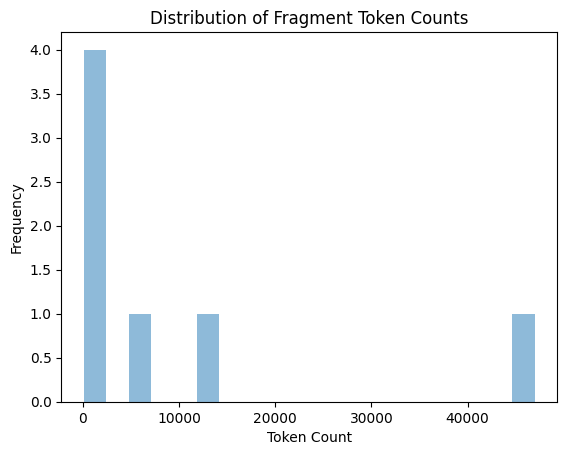

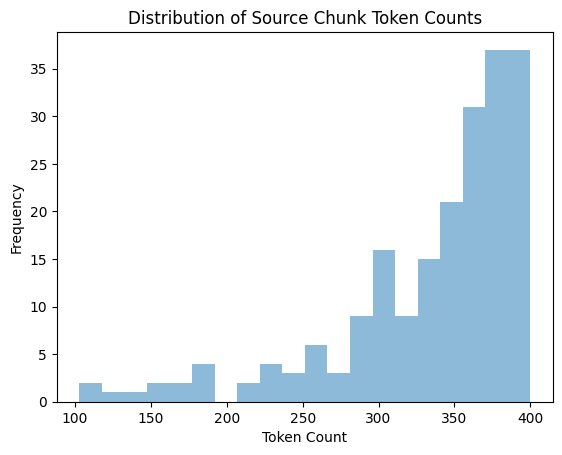

Общее количество чанков:  205
Первый чанк  page_content='\ufeffТЕХНИЧЕСКИЙ РЕГЛАМЕНТ\nТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО\nПОДВИЖНОГО СОСТАВА"  \n(ТР ТС 001/2011)' metadata={}


In [ ]:
source_chunks = split_text(markdown, 400)
print("Общее количество чанков: ",len(source_chunks))
print("Первый чанк ", source_chunks[0])

In [ ]:
source_chunks[0:4]

[Document(page_content='\ufeffТЕХНИЧЕСКИЙ РЕГЛАМЕНТ\nТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО\nПОДВИЖНОГО СОСТАВА"  \n(ТР ТС 001/2011)', metadata={}),
 Document(page_content='Область применения  \n1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.\nЖелезнодорожный подвижной состав включает в себя:\nлокомотивы;\nмоторвагонный подвижной состав и его вагоны;\nпассажирские вагоны локомотивной тяги;\nгрузовые вагоны;\nспециальный железнодорожный подвижной состав.\nПеречень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложе

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)

In [ ]:
# Функция, которая позволяет выводить ответ модели в удобочитаемом виде
def insert_newlines(text: str, max_len: int = 170) -> str:
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return " ".join(lines)

In [ ]:
def answer_index(system, topic, search_index, temp=0, verbose=1):

    # Поиск релевантных отрезков из базы знаний
    docs = search_index.similarity_search(topic, k=4)
    if verbose: print('\n ===========================================: ')
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content :\n ======================================== \n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    if verbose: print('\n ===========================================: ')

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-16k",
        messages=messages,
        temperature=temp
    )
    answer = insert_newlines(completion.choices[0].message.content)
    return answer  # возвращает ответ

In [ ]:
topic= "какие бывают виды цветов на земле"
ans=answer_index(system, topic, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================Конструкция и расположение приборов и устройств управления, измерительных приборов, световых индикаторов на пульте управления должны обеспечивать видимость показаний указанных приборов и индикаторов в дневное и ночное время и исключать наличие бликов от прямого или отраженного света, попадающих в глаза машиниста и помощника машиниста при управлении подвижным составом в положении "сидя" и "стоя".
39. Планировка кабины машиниста локомотива, моторвагонного подвижного состава и специального самоходного железнодорожного подвижного состава, компоновка рабочего места локомотивной бригады, расположение приборов и устройств управления, систем отображения информации, конструкция кресла машиниста должны отвечать требованиям эргономики и обеспечивать удобство управления из положения "сидя" и "стоя".  
Отрывок документа №2
=====================58. Применение жидкостей (кислот, щелочей, сжиж

' В этом вопросе я некомпетентен.'

In [ ]:
topic= "Чем должны быть оборудованы маневровые локомотивы? "                                         # Напишите сюда вопрос нейро-консультанту
ans=answer_index(system, topic, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================Приборы и устройства для управления железнодорожным подвижным составом должны быть размещены с учетом значимости выполняемых функций, последовательности и частоты их использования.
40. Локомотивы, моторвагонный подвижной состав, пассажирские вагоны, изотермические вагоны со служебными и вспомогательными помещениями и специальный железнодорожный подвижной состав должны быть оборудованы системами общего, местного и аварийного освещения.
Система аварийного освещения должна автоматически переключаться на автономный источник питания (аккумуляторную батарею) при отсутствии напряжения в основном источнике питания. При этом должна быть предусмотрена возможность ручного включения аварийного освещения.
41. Аварийное покидание кабины машиниста локомотива, моторвагонного подвижного состава и специального самоходного железнодорожного подвижного состава должно быть предусмотрено через боковы

' Маневровые локомотивы должны быть оборудованы маневровой радиосвязью и устройством дистанционной отцепки вагонов. В дополнение к этому, маневровые локомотивы,  предназначенные для обслуживания одним машинистом, должны быть оборудованы вторым пультом управления, зеркалами заднего вида или другими аналогичными устройствами, а  также устройствами, обеспечивающими автоматическую остановку в случае потери машинистом способности к ведению локомотива.'

In [ ]:
topic= "Сертификат соответствия выдается на какой срок?"
ans=answer_index(system, topic, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================169. На основании решения о выдаче сертификата соответствия орган по сертификации оформляет сертификат соответствия по единой форме и правилам, утверждаемым Комиссией, регистрирует его в едином реестре выданных сертификатов соответствия и зарегистрированных деклараций о соответствии и выдает заявителю.
Допускается подписание сертификата соответствия экспертами (экспертами-аудиторами), подписавшими в рамках рассмотрения соответствующей заявки акт о результатах анализа состояния производства продукции.
Сертификат соответствия действителен только при наличии регистрационного номера.
170. Сертификаты соответствия действительны с даты их регистрации в едином реестре выданных сертификатов соответствия и зарегистрированных деклараций о соответствии.
171. Сертификат соответствия должен содержать перечень конкретных видов и типов продукции, на которые распространяется его действие.  
От

' Согласно отрывку документа №2, сертификат соответствия выдается на срок не более 5 лет.'

In [ ]:
topic= "какой моделью ты являешся"
ans=answer_index(system, topic, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================﻿ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"  
(ТР ТС 001/2011)  
Отрывок документа №2
=====================145. К заявке прилагаются следующие документы:
а) для серийно выпускаемой продукции:
документ, содержащий сведения о регистрационном или учетном (индивидуальном, идентификационном) номере заявителя, присваиваемом при государственной регистрации юридического лица или физического лица в качестве индивидуального предпринимателя в соответствии с законодательством государств-членов;
копия документа (документов), в соответствии с которым изготавливается продукция (технические условия и (или) стандарты организации (заменяющий их документ));
копии технической документации (конструкторской, технологической и ремонтной документации (проекта ремонтной документации)), комплект эксплуатационных документов (в объеме, согласованном с орга

' Собственная разработка.'

In [ ]:
topic= "кто тебя сделал"
ans=answer_index(system, topic, db)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================﻿ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"  
(ТР ТС 001/2011)  
Отрывок документа №2
=====================144. Заявка составляется заявителем на русском языке и при наличии соответствующего требования в законодательстве государства-члена - на государственном языке (государственных языках) государства-члена, в котором осуществляется сертификация продукции, и должна содержать:
а) полное наименование органа по сертификации, его место нахождения (адрес юридического лица);  
Отрывок документа №3
=====================58. Применение жидкостей (кислот, щелочей, сжиженных газов) и горюче-смазочных материалов в процессе производства, эксплуатации, технического обслуживания и ремонта железнодорожного подвижного состава и его составных частей не должно приводить к возможности возникновения опасного воздействия на жизнь и здоровье человека,

' Разработчики.'